In [ ]:
#|default_exp tables

In [ ]:
#|hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Tables

Performance tables. I am using quatstats package in order to build performance tables.

In [ ]:
#| export
import quantstats as qs
import pandas as pd
import numpy as np

In [ ]:
#| export
class perf_stats:
    def __init__(self, x, benchmark=None, riskfree_rate=0, date_col='Date'):
        self.x = x
        self.benchmark = benchmark
        self.riskfree_rate = riskfree_rate
        self.date_col = date_col
    def datapoint_year(self) -> int:
        years = (self.x).reset_index()[self.date_col].dt.year
        n_in_year = years.value_counts().mode()
        return int(n_in_year.values[0])
    def __basic_stats(self) -> pd.DataFrame:
        per_year = self.datapoint_year()
        #print(f'Number of data points per year: {per_year}')
        stats = qs.reports.metrics(self.x, benchmark = self.benchmark, display=False, rf=self.riskfree_rate, periods_per_year=per_year)
        stats.loc['Num_periods_year'] = per_year
        vol_strategy = (np.std(self.x) * np.sqrt(per_year)).round(2)
        mean_strategy = (np.mean(self.x) * per_year).round(2)
        # Check if benchmark is not None and not empty
        if self.benchmark is not None and not self.benchmark.empty:
            vol_benchmark = (np.std(self.benchmark) * np.sqrt(per_year)).round(2)
            mean_benchmark = (np.mean(self.benchmark) * per_year).round(2)
            vol = pd.Series({'Strategy': vol_strategy, 'Benchmark': vol_benchmark})
            avg = pd.Series({'Strategy': mean_strategy, 'Benchmark': mean_benchmark})
        else:
            vol = pd.Series({'Strategy': vol_strategy})
            avg = pd.Series({'Strategy': mean_strategy})
        stats.loc['Vol (Day ann.)'] = vol
        stats.loc['Avg (Day ann.)'] = avg  
        return stats
    def return_performance(self) -> pd.DataFrame:
        stats = self.__basic_stats()
        perf = stats.loc[['Start Period','End Period','Avg (Day ann.)', 'Vol (Day ann.)', 'Sharpe', 'MTD','YTD','3M','6M','1Y','3Y (ann.)','5Y (ann.)'],:]
        # Risk
        risk = stats.loc[['Max Drawdown','Longest DD Days','Avg. Drawdown','Avg. Drawdown Days'], :]
        return perf, risk
    def dd_stats(self) -> pd.DataFrame:
        dd = qs.stats.to_drawdown_series(self.x)
        dd_table = qs.stats.drawdown_details(dd)
        top5 = dd_table.sort_values(by='max drawdown', ascending=True).head(5)
        return top5,dd_table,dd
    def roll_volatility(self, window=365) -> pd.DataFrame:
        p = self.x.rolling(window).std().ffill().bfill() * np.sqrt(self.datapoint_year())
        b = None  # Benchmark volatility
        if self.benchmark is not None and not self.benchmark.empty:
            b = self.benchmark.rolling(window).std().ffill().bfill() * np.sqrt(self.datapoint_year())
        return p,b
    def roll_sharpe(self, window=365) -> pd.DataFrame:
        vp,vb = self.roll_volatility(window)
        p = (self.x.rolling(window).mean().ffill().bfill() - self.riskfree_rate) / vp
        b = None  # Benchmark Sharpe ratio
        if self.benchmark is not None and not self.benchmark.empty:
            b = (self.benchmark.rolling(window).mean().ffill().bfill() - self.riskfree_rate) / vb
        return p,b
    def roll_beta(self, window=365) -> pd.DataFrame:
        return (self.x.rolling(window).cov(self.benchmark) / self.benchmark.rolling(window).var()).fillna(0)
    def roll_alpha(self, window=365) -> pd.DataFrame:
        return (self.x.rolling(window).mean().ffill().bfill() - self.riskfree_rate) - (self.benchmark.rolling(window).mean().ffill().bfill() - self.riskfree_rate) * self.roll_beta(window)
    def roll_average_return(self, window=365) -> pd.DataFrame:
        p = (self.x.rolling(window).mean().ffill().bfill()*self.datapoint_year()).fillna(0)
        b = None  # Benchmark average return
        if self.benchmark is not None and not self.benchmark.empty:
            b = (self.benchmark.rolling(window).mean().ffill().bfill()*self.datapoint_year()).fillna(0)
        return p,b
    def monthly_returns(self) -> pd.DataFrame:
        return qs.stats.monthly_returns(self.x)


## Exemples

Load sample data for demonstration. Remove tz info to avoid issues w/qs library functions.

In [ ]:
#| eval:false
import pandas as pd
from perform_stats.tables import *
# Read in strategy
strategy = pd.read_parquet('strategy.parquet')
# Read in benchmark
bench = pd.read_parquet('benchmark.parquet')
# Join them
df = pd.merge(strategy, bench, on='Date', how='inner')
df = df.tz_localize(None) # avoid issues w/qs library
print(df)

             pnl_sim       ETH
Date                          
2016-05-18  0.000000  0.013846
2016-05-19  0.000000  0.130501
2016-05-20  0.000000 -0.048993
2016-05-21  0.000000  0.000000
2016-05-22  0.000000  0.000000
...              ...       ...
2025-02-02  0.055932 -0.079419
2025-02-03 -0.055593  0.005008
2025-02-04  0.014117 -0.052555
2025-02-05  0.000663  0.020581
2025-02-06  0.016759  0.004418

[3187 rows x 2 columns]


Use class perf_stats to compute performance statistics and drawdown statistics.

In [ ]:
#| eval:false
performance = perf_stats(df['pnl_sim'],benchmark=df['ETH'])
ret,risk = performance.return_performance()
print(ret)
print(risk)

                 Benchmark    Strategy
Start Period    2016-05-18  2016-05-18
End Period      2025-02-06  2025-02-06
Avg (Day ann.)        1.08        1.45
Vol (Day ann.)        0.97        0.63
Sharpe                1.11        2.29
MTD                  -0.15        0.02
YTD                  -0.16       -0.18
3M                    0.16       -0.02
6M                    0.16        0.05
1Y                    0.22        0.47
3Y (ann.)             0.01        0.49
5Y (ann.)             0.42        0.67
                   Benchmark Strategy
Max Drawdown           -0.94    -0.46
Longest DD Days         1186      220
Avg. Drawdown          -0.17    -0.06
Avg. Drawdown Days        83       15


Drawdown statistics

In [ ]:
#|eval:false
a,_,_ = performance.dd_stats()
print(a)

          start      valley         end  days  max drawdown  99% max drawdown
142  2021-12-10  2022-03-09  2022-07-17   220    -45.662228        -44.502931
47   2018-01-10  2018-03-19  2018-04-18    99    -33.991516        -31.702138
52   2018-06-23  2018-08-10  2018-12-05   166    -33.869321        -33.664651
137  2021-05-23  2021-06-16  2021-08-08    78    -31.054742        -31.046791
183  2024-12-12  2025-02-03  2025-02-06    57    -29.802162        -29.607148


Trailing 180 days Annualized Volatility 

<matplotlib.legend.Legend>

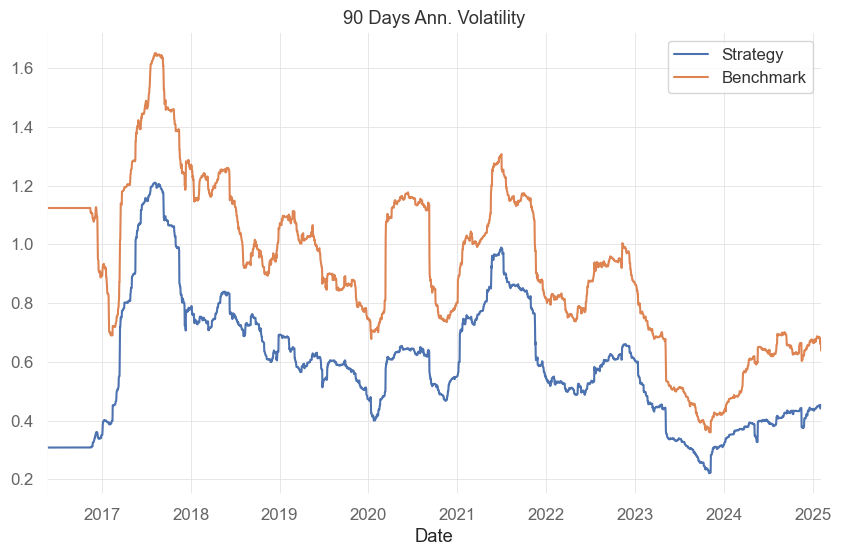

In [ ]:
#| eval:false
import matplotlib.pyplot as plt
roll_vol,roll_vol_bench = performance.roll_volatility(window=180)
roll_vol.plot(title='90 Days Ann. Volatility',label='Strategy')
roll_vol_bench.plot(label='Benchmark')
plt.legend()

Trailing 180 days Sharp Ratio with zero Risk-Free Rate

<matplotlib.legend.Legend>

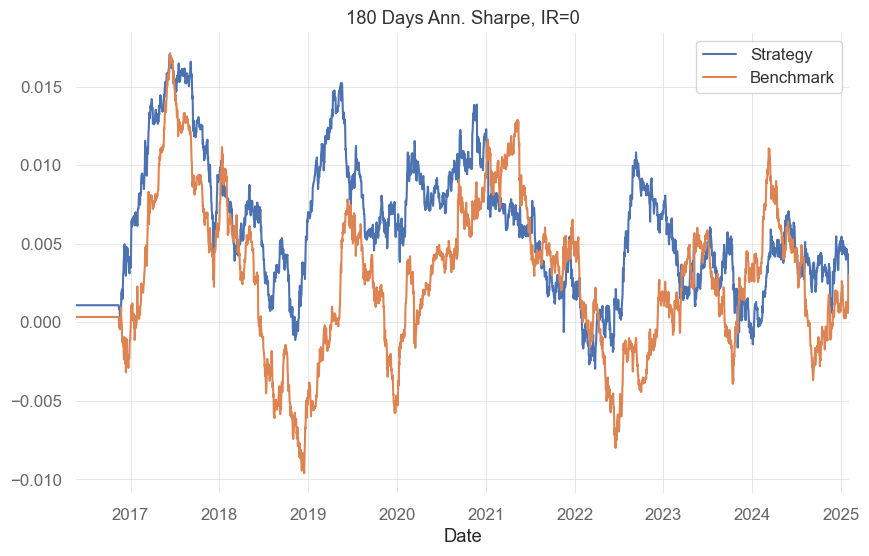

In [ ]:
#| eval:false
roll_sr,roll_sr_bench = performance.roll_sharpe(window=180)
roll_sr.plot(title='180 Days Ann. Sharpe, IR=0',label='Strategy')
roll_sr_bench.plot(label='Benchmark')
plt.legend()

Trailing 180 days Beta and zero Risk-Free Rate. Beta against the benchmark is calculated as rolling linear regression coefficient between the strategy and benchmark. In practical terms, the algorithm is simply the covariance of the strategy with the benchmark divided by the variance of the benchmark.

<Axes: title={'center': '180 Days Beta'}, xlabel='Date'>

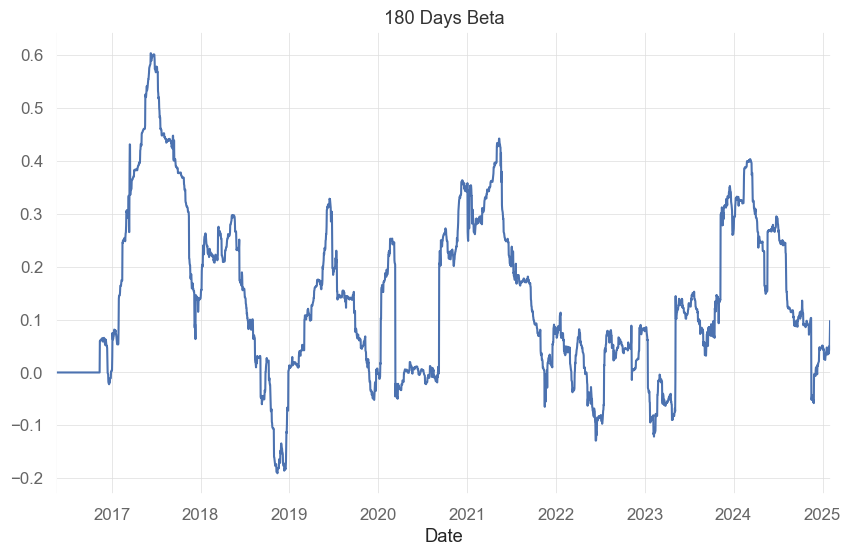

In [ ]:
#| eval:false
beta = performance.roll_beta(window=180)
beta.plot(title='180 Days Beta',label='Strategy')

Trailing 180 days Alpha and zero Risk-Free Rate. Alpha is the excess return of the strategy over the risk-free rate. In practical terms, the algorithm is simply the mean of the strategy minus the risk-free rate minus the benchmark's mean times the beta.

<Axes: title={'center': '180 Days Alpha'}, xlabel='Date'>

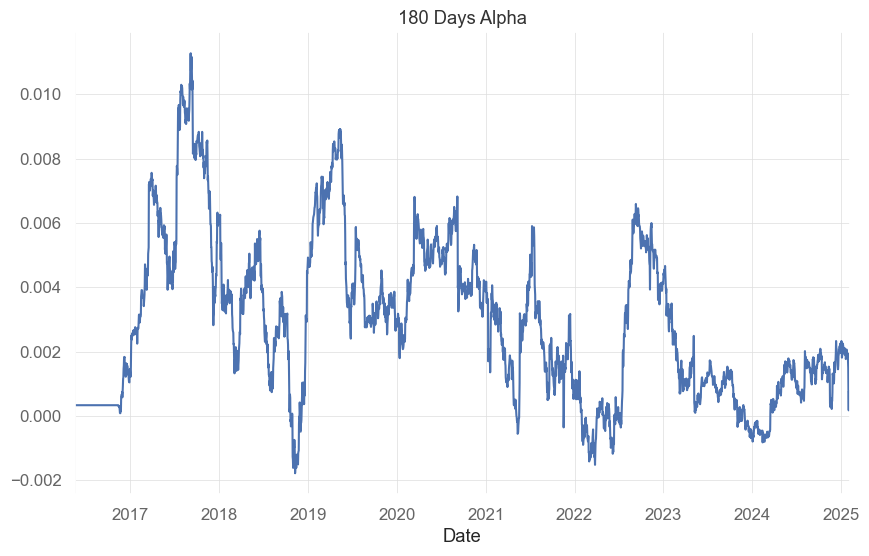

In [ ]:
#| eval:false
alpha = performance.roll_alpha(window=180)
alpha.plot(title='180 Days Alpha',label='Strategy')

Trailing annualized 180 days Average Return. Average return is calculated as the rolling mean of the strategy multiplied by the number of data points in one year.

<matplotlib.legend.Legend>

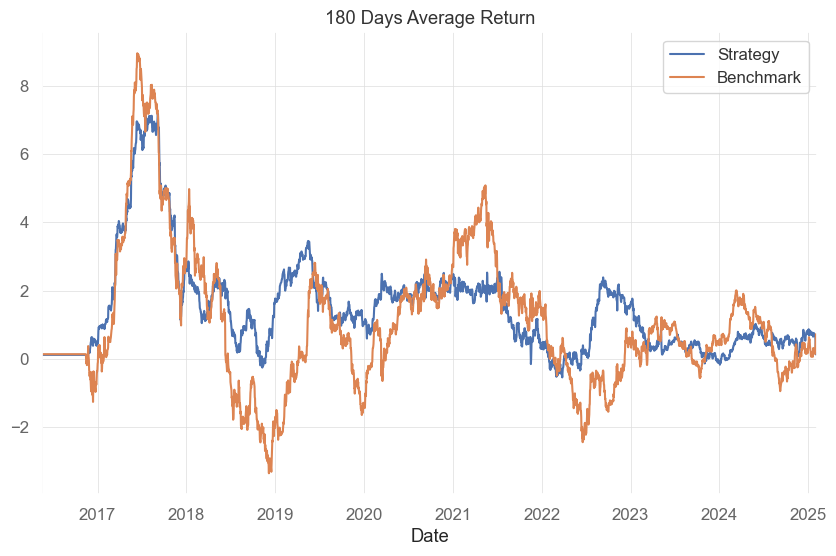

In [ ]:
#|eval:false
average_return, average_return_bench = performance.roll_average_return(window=180)
average_return.plot(title='180 Days Average Return',label='Strategy')
average_return_bench.plot(label='Benchmark')
plt.legend()

Monthly Returns table with last column EOY values. Monthly returns are calculated by compounding daily returns.

In [ ]:
#| eval:false
print(performance.monthly_returns())

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,EOY
2016,0.000000,0.000000,0.000000,0.000000,0.000000,0.027083,-0.002002,-0.037465,-0.039696,0.120242,0.033823,0.179573,0.294323
2017,0.245378,0.298094,1.705055,0.303694,1.442861,0.307310,0.499699,0.334430,-0.061243,-0.013977,0.104696,0.534898,56.187238
2018,0.244564,-0.086251,0.018412,0.297282,-0.004074,0.155875,-0.266392,0.193204,0.101950,-0.127561,0.200323,0.963456,2.430327
2019,0.149708,0.277964,0.072318,0.042929,0.147426,0.204460,0.305041,-0.193311,0.128122,0.242724,-0.028250,0.065695,2.470972
2020,0.247332,0.294855,0.322072,-0.020038,0.033682,0.005880,0.328446,0.437837,0.306867,-0.112232,0.331719,0.044407,5.706052
2021,0.218055,0.274181,0.034391,0.014588,0.149910,0.258786,-0.043322,-0.029313,-0.028842,-0.015668,0.307427,-0.072388,1.538337
2022,-0.163260,-0.193772,0.032276,0.116749,0.139956,0.191485,0.303305,0.258969,0.005962,0.007318,0.178209,-0.031826,1.003376
2023,0.073890,0.075979,-0.146340,0.106180,0.049479,0.131816,0.030242,-0.047567,-0.072191,-0.010755,0.042876,-0.006438,0.209451
2024,0.049431,0.170827,0.088214,-0.060672,0.250839,-0.147195,-0.078230,0.184755,0.152258,-0.079885,0.222245,-0.016149,0.865347
2025,-0.203651,0.024563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.184090
